In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gaussian_process import fit_2d_gp
import time

from models.patchgpt import PatchGPT
import torch

/opt/anaconda3/envs/gpt-ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
object_ids = np.unique(df['object_id'].values)

In [4]:
tokenizer = LCTokenizer(config["min_flux"], config["max_flux"], config["num_bins"], config["max_delta_time"],
                            config["num_time_bins"], bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=5)

In [5]:
start_time = time.time()
#tokenizer.encode(df)
print(time.time() - start_time)

2.6941299438476562e-05


0.2864420413970947


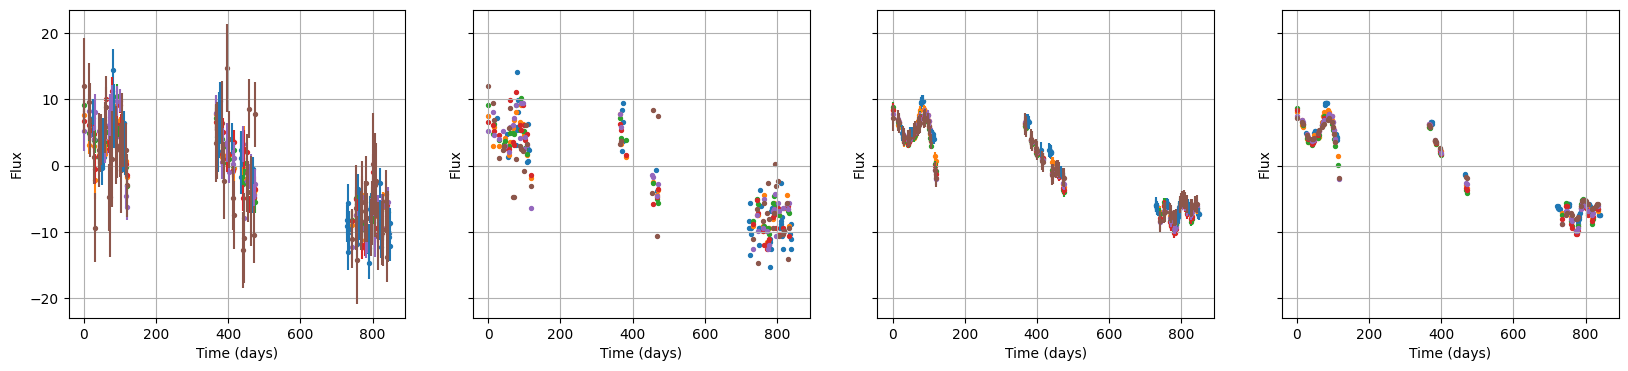

In [37]:
for object_id in object_ids[1:2]:
    df_object = df.loc[df['object_id'] == object_id]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask) = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    print(time.time() - start_time)
    plot_lightcurve([df_object, tokenizer.decode(tokenizer.encode(df_object)), resampled_df, tokenizer.decode(tokenizer.encode(resampled_df))])

In [38]:
sampled_obs.shape

(6, 849)

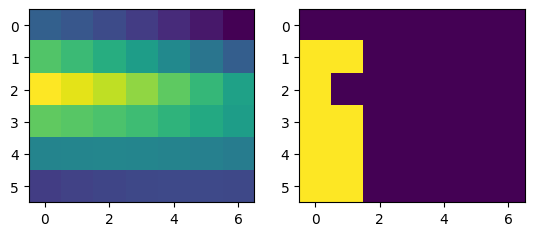

In [39]:
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(sampled_obs[:,0:7])
    axes[1].imshow(sampled_mask[:,0:7])
    plt.show()

In [40]:
patchify = PatchGPT(seq_len=sampled_obs.shape[1], patch_size=7, dim=16, channels=6)

In [41]:
x = torch.tensor(np.expand_dims(sampled_obs, 0), dtype=torch.float32)

In [42]:
patchs = patchify(x)

In [43]:
patchs.size()


torch.Size([1, 122, 16])

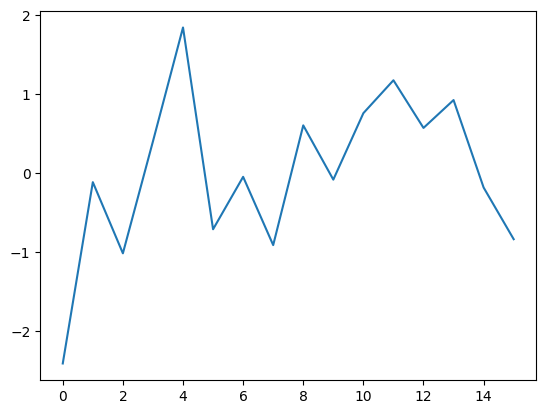

In [44]:
plt.plot(patchs[0,1,:].detach().numpy())